In [1]:
suppressPackageStartupMessages(library(dplyr))
library(ggplot2)
suppressPackageStartupMessages(library(Seurat))
library(pheatmap)
library(RColorBrewer)
library(harmony)
source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT/BICAN_help.R")

### this is just to resize jupyter notebook plot size
library(repr)

library(reticulate)
library(anndata)

Warning message:
“package ‘ggplot2’ was built under R version 4.4.3”
Warning message:
“package ‘SeuratObject’ was built under R version 4.4.3”
Warning message:
“package ‘sp’ was built under R version 4.4.2”
Loading required package: Rcpp

Warning message:
“package ‘scales’ was built under R version 4.4.3”
Warning message:
“package ‘Matrix’ was built under R version 4.4.3”
Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal


Warning message:
“package ‘reticulate’ was built under R version 4.4.3”

Attaching package: ‘anndata’


The following object is masked from ‘package:SeuratObject’:

    Layers




In [3]:
hg38 <- read.table("/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.v43.10X.bed", header = F)
hg38$V4 <- gsub("^([^.]+).*$", "\\1", hg38$V4)
head(hg38)
dim(hg38)

,V1,V2,V3,V4,V5,V6
,<chr>,<int>,<int>,<chr>,<chr>,<chr>
1,chr1,11868,14409,+,ENSG00000290825,DDX11L2
2,chr1,29553,31109,+,ENSG00000243485,MIR1302-2HG
3,chr1,34553,36081,-,ENSG00000237613,FAM138A
4,chr1,57597,64116,+,ENSG00000290826,ENSG00000290826
5,chr1,65418,71585,+,ENSG00000186092,OR4F5
6,chr1,89294,133723,-,ENSG00000238009,ENSG00000238009


[1] 38369     6

## Read SMART-seq scRNA-seq reference

 https://brain-map.org/our-research/cell-types-taxonomies/cell-types-database-rna-seq-data/human-multiple-cortical-areas-smart-seq

In [5]:
data <- data.table::fread("data/matrix.csv", sep = ",")
meta <- data.table::fread("data/metadata.csv", sep = ",")

In [8]:
ncol(data)
intersect(colnames(data), hg38$V6) %>% length

[1] 50282

[1] 20620

In [16]:
mtx <- mltools::sparsify(data[,-1], sparsifyNAs = FALSE, naCols = "none")
qname <- unlist(data[,1]) %>% as.character
rownames(mtx) <- qname
mtx <- mtx[,intersect(colnames(data), hg38$V6)]

In [20]:
unique(qname) %>% length

[1] 49417

In [35]:
### Cluster without batch correction
qname <- unlist(meta[,1]) %>% as.character
tmp <- CreateAssayObject(counts = t(mtx))
tmp <- CreateSeuratObject(tmp, meta.data = as.data.frame(meta, row.names = qname))

tmp <- seurat_onestep_clust(tmp, npc = 30, res = 0.3)
gc()

Perform log CPM normalization...


Warning message:
“The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


Perform variable features selection using Brennecke's method...
number of variable genes calculated by hicat method: 2257
Perform data scaling and PCA...


Centering and scaling data matrix



Number of PC selected for downstream analysis: 30
Number of neighbors selected for downstream analysis: 15
Perform UMAP embedding...
resolution used for leiden clustering: 0.3


Warning message:
“Assay RNA changing from Assay to Assay5”


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3812795,203.7,7133402,381.0,7133402,381.0
Vcells,5161468051,39378.9,6994958224,53367.3,8804220929,67170.9


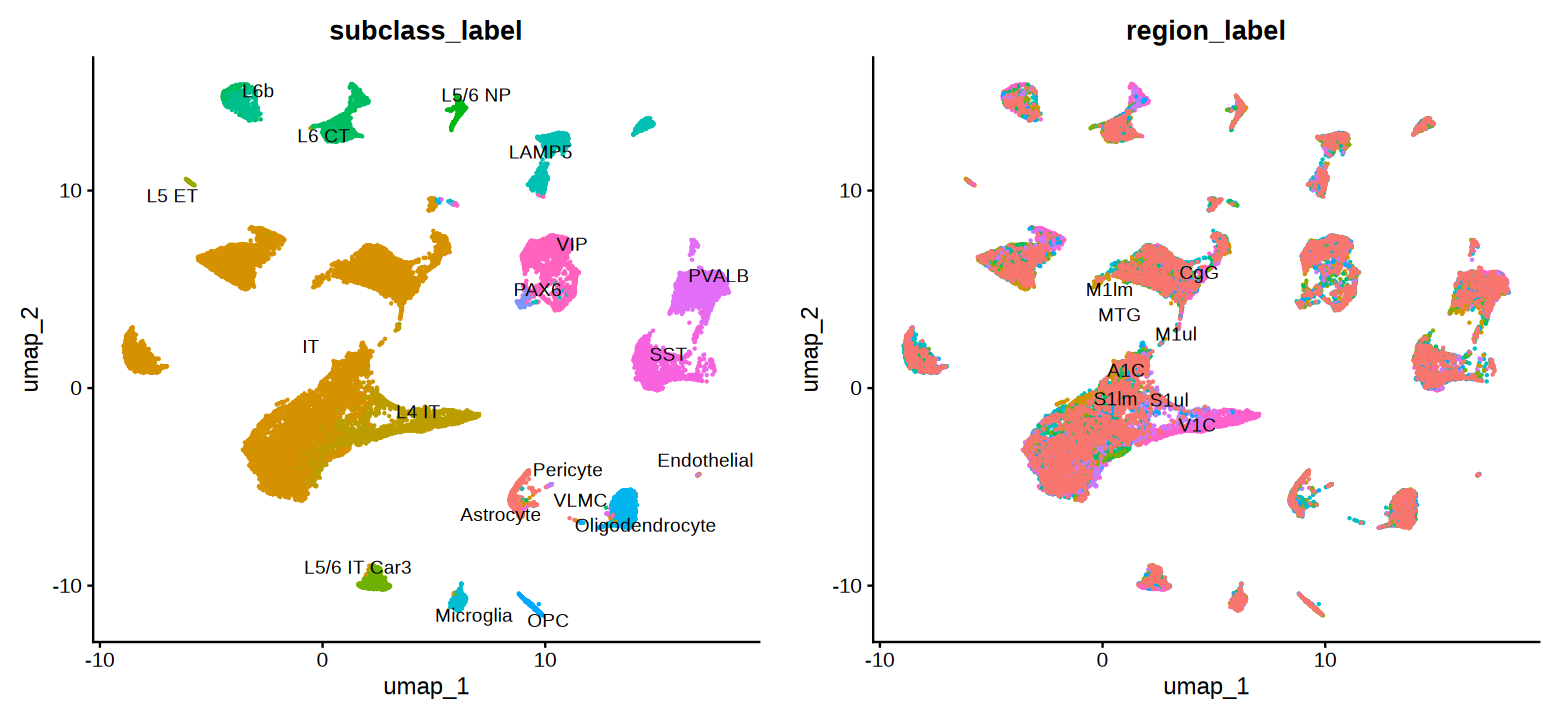

In [46]:
qcells <- tmp@meta.data %>% filter(subclass_label != "") %>% rownames
t1 <- DimPlot(tmp, group.by = "subclass_label", label = T, repel = T, cells = qcells) + NoLegend()
t2 <- DimPlot(tmp, group.by = "region_label", label = T, repel = T, cells = qcells) + NoLegend()

options(repr.plot.width = 13, repr.plot.height = 6)
cowplot::plot_grid(t1, t2, ncol = 2)

In [45]:
qs::qsave(tmp, "data/rna_seurat_object.qs")

Warning message:
“ggrepel: 74 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


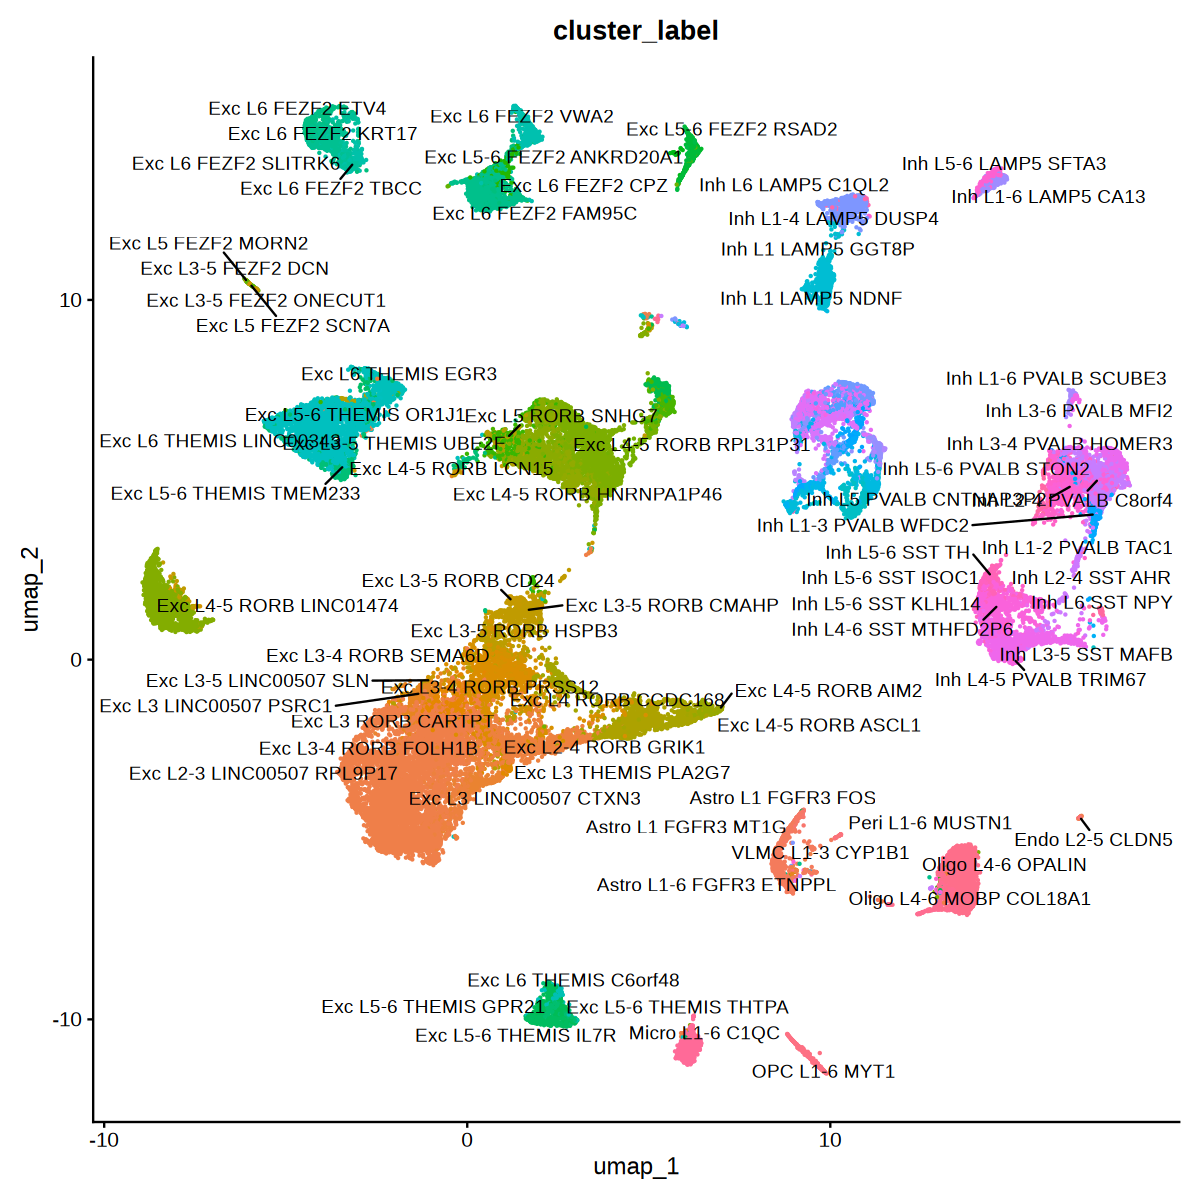

In [47]:
options(repr.plot.width = 10, repr.plot.height = 10)
DimPlot(tmp, group.by = "cluster_label", label = T, repel = T, cells = qcells) + NoLegend()

In [58]:
### Subset for integration
qlist <- list()
qmeta <- tmp@meta.data %>% filter(subclass_label != "")
for (f in unique(qmeta$cluster_label)){
    qcells <- qmeta %>% filter(cluster_label == f) %>% rownames
    if (length(qcells) >= 1000){
        qcells <- sample(qcells, size = 1000, replace = F)
    }
    qlist[[f]] <- qcells
}

unlist(qlist) %>% unique %>% length

[1] 36042

In [59]:
tmp <- subset(tmp, cells = as.character(unlist(qlist)))
qs::qsave(tmp, "data/rna_subset_for_int.qs")